# Time-dependent heat equation

We will solve the heat equation by discretizing time into small time intervals and applying standard time step methods, that is, by solving a sequence of variational problems.

$$ \frac{\partial u}{\partial t} = \nabla²u + f \; in \; \Omega \; x \; (0,T],$$

$$ u = u_D \; on \; \Gamma_{\mathrm{D}}\; x \; (0, T], $$

$$ u = u_0 \; at \; t = 0. $$


We will use the following data:

* $\Omega = S_0 \setminus C_0 $
* $S_0$ is the unit square centered at $(0.5, 0.5)$
* $C_0$ is a circle with radius $0.25$ centered at $(0.5, 0.5)$
* $\Gamma_{\mathrm{D}}$ is the boundary of the circle
* $f = 0$
* $u_{\mathrm{D}} = 100°C$
* $u_{\mathrm{0}} = 1000°C$

# Variational formulation

For this time-discrete version of the heat equation, we will use the *backward Euler* or *implicit Euler* discretization.

We will consider the alternative form of the variational formulation of heat equation:

$$ F_{n+1}(u;v)=0$$

Where:

$$F_{n+1}(u;v)= \int_{\Omega} (uv+\Delta t \nabla u \cdot \nabla v - (u^n + \Delta t f^{n+1})v) \,\mathrm{d}x$$

Also, we have to solve the variational problem in each time step, then we also need to approximate the initial condition:

$$ a_{0}(u,v) = L_{0}(v)$$

with:

$$a_{0}(u,v) = \int_{\Omega} uv \,\mathrm{d}x$$

$$L_{0}(u,v) = \int_{\Omega} u_{0}v \,\mathrm{d}x$$

### Importing FEniCS and useful libraries

We import `FEniCS` and the meshing library `mshr`. We also import `matplotlib` to make some plots.

In [1]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

### Defining the time steps

In [2]:
T = 3.0              # final time
num_steps = 300      # number of time steps
dt = T / num_steps   # time step size

### Defining the mesh

We create the mesh by using boolean operator from `mshr`. We define an square and a circle and then we set difference btw them.

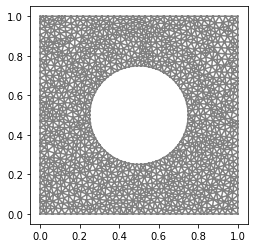

In [3]:
S0 = Rectangle(Point(0, 0), Point(1, 1))
C0 = Circle(Point(0.5, 0.5), 0.25)
domain = S0  - C0 

mesh = generate_mesh(domain, 32)
plot(mesh)

### Defining the finite element function space

After we create the mesh, we have to define the finite element function space. In our case, we will use standard piecewise linear $P_1$ function space.

In [4]:
V = FunctionSpace(mesh, 'P', 1)

### Defining boundary conditions

The boundary condition can be defined by specifying all points on the boundary closer to the circle center than a distance slightly larger than the radius $r = 0.25$.

In [5]:
# Circle
u_D = 100.0

def boundary(x, on_boundary):
    d0 = sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    return(on_boundary and d0 < 0.3)

bc = DirichletBC(V, u_D, boundary)

### Define initial value

In [6]:
u_0 = Expression('1000', degree=1)
u_n = interpolate(u_0, V)

### Define Trial and Test functions

In [7]:
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

### Bilinear and linear forms

In [8]:
 #Constant thermal diffusivity
k = Constant(0.1)

# We define the variational problem with the form: F(u,v) = 0
F = u*v*dx + dt*k*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx

# We let to FEniCS to choose the terms for the bilinear and linear form
# by using: "lhs=left hand side" and "rhs=right hand side"
a, L = lhs(F), rhs(F) 

## Postprocessing
To postprocess the solution using Paraview, we save the solution to VTK format (file suffix `.pvd`).

In [9]:
vtkfile = File('Trascient heat equation in plate with a hole/solution.pvd')

### Solving the variational problem
The variational problem can now be solved by calling the `solve` command.

In [10]:
# Time-stepping
u = Function(V)
t = 0

for n in range(num_steps):
    # Update current time
    t += dt
    
    # Compute solution
    solve(a == L, u, bc)
    
    # Save to file and plot solution
    vtkfile << (u, t)

    # Compute the maximum temperature at t = i
    max_temp = np.abs(u.vector().get_local()).max()
    print('t = %.2f: Max. temperature = %.3g' % (t, max_temp))
    
    # Update previous solution
    u_n.assign(u)

t = 0.01: Max. temperature = 1e+03
t = 0.02: Max. temperature = 1e+03
t = 0.03: Max. temperature = 1e+03
t = 0.04: Max. temperature = 1e+03
t = 0.05: Max. temperature = 1e+03
t = 0.06: Max. temperature = 999
t = 0.07: Max. temperature = 999
t = 0.08: Max. temperature = 998
t = 0.09: Max. temperature = 997
t = 0.10: Max. temperature = 995
t = 0.11: Max. temperature = 993
t = 0.12: Max. temperature = 990
t = 0.13: Max. temperature = 987
t = 0.14: Max. temperature = 983
t = 0.15: Max. temperature = 979
t = 0.16: Max. temperature = 974
t = 0.17: Max. temperature = 968
t = 0.18: Max. temperature = 962
t = 0.19: Max. temperature = 956
t = 0.20: Max. temperature = 949
t = 0.21: Max. temperature = 941
t = 0.22: Max. temperature = 934
t = 0.23: Max. temperature = 926
t = 0.24: Max. temperature = 918
t = 0.25: Max. temperature = 909
t = 0.26: Max. temperature = 900
t = 0.27: Max. temperature = 892
t = 0.28: Max. temperature = 883
t = 0.29: Max. temperature = 873
t = 0.30: Max. temperature = 864


### Plotting the solution
We can use the `plot` command to visualize the solution.

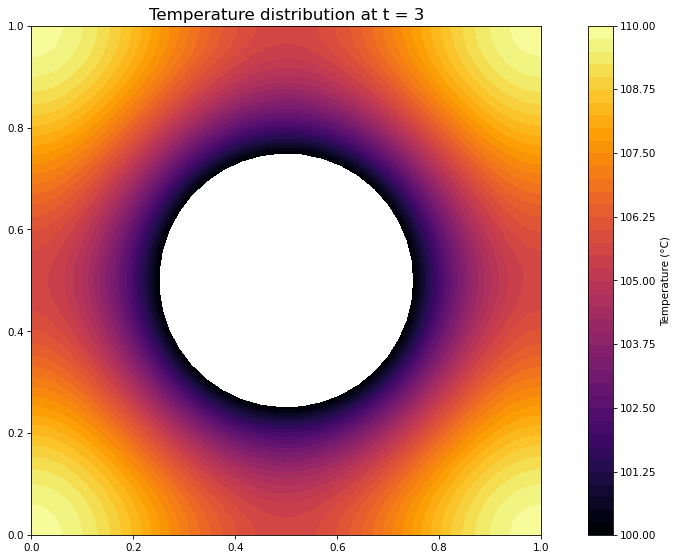

In [11]:
plt.figure(figsize = (16, 9), dpi=75)
p = plot(u, cmap = 'inferno')
plt.title('Temperature distribution at t = %g'%t, fontsize=16)
plt.colorbar(p, label = 'Temperature (°C)')

filename = 'Trascient heat equation in plate with a hole/trascient-heat-equation.png'
plt.savefig(filename, dpi=300)